# Step 1:  Implement the Histogram of Curvature Scale

Write a function called HoCS that returns a histogram of curvature scale feature vector for a given region.  The inputs to your function should be:

- `B`: a binary image that contains exactly one foreground connected component.
- `min_scale`: The smallest scale (circle radius) at which to calcluate curvature
- `max_scale`: The largest scale (circle radius) at which to calculate curvature
- `increment`: The increment at which intermediate curvatures should be calculated (must be a positive integer)
- `num_bins`: The number of bins in the histogram of curvature for a single scale (must be a positive integer)

Your function should compute a histogram of curvature for each scale, starting at `min_scale` ending at (at most) `max_scale`, and for intermediate scales at increments of `increment`.  For example, if `min_scale`=4 and `max_scale`=20, and `increment`=3, then the function should compute a histogram of curvature for scales 4, 7, 10, 13, 16, and 19.  Each histogram at each scale should have `num_bins` bins.  Curvature must be computed using the normalized area integral invariant method described on Slide 39 of the Topic 9 lecture notes.  

Normalize each histogram at each scale.

To keep things straightforward, your functions hould only consider the outer perimeter of the input region; ignore the boundaries of holes in the region.

After computing the histogram of curvature at each of the specified scales, all of the histograms should be concatenated into a single one-dimensional array (feature vector) and then returned.

_Implementation hint:  You can calculate the normalized area integral invariant of each pixel efficiently using linear filtering.  You will find the function `skimage.morphology.disk()` function useful for designing the appropriate filter masks._

_Implementation hint:  Most of the heavy lifting here can be done with module functions from `skimage`, `numpy`, and `scipy`.  Many of the functions mentioned in class and in the notes will be useful.  One that we might not have covered, but will be very handy is `numpy.histogram()`.  When you use it, makes sure you specify both the `bins` and `range` optional arguments. Also note that `numpy.histogram()` returns TWO things.  You only need the first one, so make sure you write your function call like this:_

`the_histogram, stuff_you_dont_need = np.histogram(...)`


In [38]:
# Code your HoCS function here
import numpy as np
import skimage.segmentation as seg
import skimage.morphology as morph
import os as os
from scipy import ndimage


def HoCS(B, min_scale, max_scale, increment, num_bins):
    '''
    Computes a histogram of curvature scale for the shape in the binary image B.  
    Boundary fragments due to holes are ignored.
    :param B: A binary image consisting of a single foreground connected component.
    :param min_scale: smallest scale to consider (minimum 1)
    :param max_scale: largest scale to consider (max_scale > min_scale)
    :param increment:  increment on which to compute scales between min_scale and max_scale
    :param num_bins: number of bins for the histogram at each scale
    :return: 1D array of histograms concatenated together in order of increasing scale.
    '''
    
    assert min_scale <= max_scale
    
    B_no_hole = ndimage.binary_fill_holes(B).astype(int)
    B_no_hole = np.pad(B_no_hole, pad_width=max_scale, mode='constant', constant_values=(False))
    bp = np.where(seg.find_boundaries(B_no_hole, connectivity=1, mode='inner') > 0)
    bp = np.transpose(np.vstack(bp))
    
    conca_hist = np.array([])
    start = min_scale
    while start <= max_scale:
        hist = FindHist(bp, B_no_hole, start, num_bins)
        conca_hist = np.concatenate((conca_hist, hist))
        start = start + increment
        
    return conca_hist

def FindHist(bdry, B, scale, num_bins):
    disc = morph.disk(scale)
    disc_area = sum(map(sum, disc))
    areas = []
    for row, col in bdry:
        areas.append(sum(map(sum, np.logical_and(B[row - scale : row + scale + 1, col - scale : col + scale + 1], disc))) * 1.0 / disc_area)
    hist, bin_edges = np.histogram(areas, range=(0.0, 1.0))
                                   
    return (hist / len(areas))

# Step 2: Test your HoCS function.

Run HoCS on `threshimage_0001.png` from the ground truth for assignment 3.  Use `min_scale=5`, `max_scale=25`, `increment=10`, `num_bins=10`.  Plot the resulting feature vector as a bar graph.  Set the y-axis limits to be between 0.0 and 1.0.  You should get a result that matches the sample output in the assignment description.


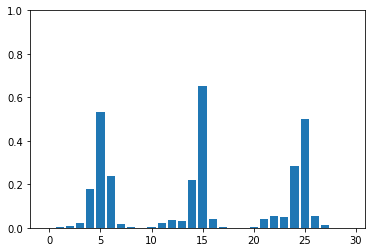

In [39]:
import skimage.io as io
import matplotlib.pyplot as plt
% matplotlib inline

# Paths for folders -- ground truth images
gt_path = os.path.join('.', 'leaftraining')
gtfilename = 'threshimage_0001.png'
I_gt = io.imread(os.path.join(gt_path, gtfilename))

conca_hist = HoCS(I_gt > 0, min_scale=5, max_scale=25, increment=10, num_bins=10)

plt.figure()
plt.ylim((0,1))
plt.bar(np.arange(len(conca_hist)), conca_hist)
plt.show()

# Step 3: Calculate training features.

Use your function from Step 1 to compute the HoCS feature for each of the training images.  Use them to train a k-nearest neigbour classifier.  It is up to you to determine the parameters for the HoCS feature such as `min_scale`, `max_scale`, etc. to maximize the classification rate.  This will require some experimentation.  Slides 19-21 of Topic 12 lecture notes will be helpful here.

Also generate the training labels here (a column-array of numbers indicating which descriptors belong to each class, e.g. use values 1,2,3 to indicate class 1, 2, and 3.).

In [46]:
import sklearn.neighbors as neigh
import os as os

# use os.walk() as in previous assignments to process the training images.
# Paths for folders -- ground truth images
gt_path = os.path.join('.', 'leaftraining')


train_X = []
train_y = []
count_train_img = 0
# Iterate over all files in the original images folder
for root, dirs, files in os.walk(gt_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue
        
        # concatenate variable root with filename to get the path to an input file.
        fname = os.path.join(root, filename)
        print(fname)
        I = io.imread(fname)
        count_train_img = count_train_img + 1
        train_X.append(HoCS(I > 0, min_scale=5, max_scale=25, increment=10, num_bins=10))
        if (count_train_img <= 10):
            train_y.append(1)
        elif (count_train_img <= 20):
            train_y.append(2)
        else:
            train_y.append(3)

./leaftraining/threshimage_0001.png
./leaftraining/threshimage_0002.png
./leaftraining/threshimage_0005.png
./leaftraining/threshimage_0007.png
./leaftraining/threshimage_0009.png
./leaftraining/threshimage_0010.png
./leaftraining/threshimage_0011.png
./leaftraining/threshimage_0015.png
./leaftraining/threshimage_0018.png
./leaftraining/threshimage_0019.png
./leaftraining/threshimage_0078.png
./leaftraining/threshimage_0080.png
./leaftraining/threshimage_0089.png
./leaftraining/threshimage_0090.png
./leaftraining/threshimage_0099.png
./leaftraining/threshimage_0100.png
./leaftraining/threshimage_0104.png
./leaftraining/threshimage_0105.png
./leaftraining/threshimage_0110.png
./leaftraining/threshimage_0113.png
./leaftraining/threshimage_0132.png
./leaftraining/threshimage_0160.png
./leaftraining/threshimage_0161.png
./leaftraining/threshimage_0162.png
./leaftraining/threshimage_0163.png
./leaftraining/threshimage_0165.png
./leaftraining/threshimage_0166.png
./leaftraining/threshimage_0

# Step 4: Train the KNN classifier using the feature vectors from the training images.

You have another opportunity here to optimize parameters.  You can experiment with the options for the KNN classifier (in partiuclar n_neighbors) to try to obtain better classification rates.  But you won't really be able to do this until after step 6, so just use default parameters to start with. 

Hint: The steps in this notebook are broken up the way they are so that you can adjust the parameters of training the classifier and then go and perform the classfication without having to re-run the calculation of the features in steps 3 and 5.  You can adjust the parameters here in step 4, and then go and re-run the test set in Step 6 without running step 5 over again -- which is good because step 5 will take a while to run.  Of course you will have to recalculate the features each time you restart PyCharm or the Jupyter Notebook server.

In [93]:
# Train the KNN classifier
ngh = neigh.KNeighborsClassifier(n_neighbors=1)
ngh.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

# Step 5: Calculate the testing features.

Compute the HoCS features for all of the testing images.  Use the same HoCS parameters you did in Step 3.  Also generate class labels for the testing image descriptors.

In [49]:
# again use os.walk() to process the testing images
# use os.walk() as in previous assignments to process the training images.
# Paths for folders -- ground truth images
test_path = os.path.join('.', 'leaftesting')


test_X = []
test_y = []
count_test_img = 0
# Iterate over all files in the original images folder
for root, dirs, files in os.walk(test_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue
        
        # concatenate variable root with filename to get the path to an input file.
        fname = os.path.join(root, filename)
        print(fname)
        I = io.imread(fname)
        count_test_img = count_test_img + 1
        test_X.append(HoCS(I > 0, min_scale=5, max_scale=25, increment=10, num_bins=10))
        if (count_test_img <= 50):
            test_y.append(1)
        elif (count_test_img <= 77):
            test_y.append(2)
        else:
            test_y.append(3)

./leaftesting/image_0003.png
./leaftesting/image_0004.png
./leaftesting/image_0009.png
./leaftesting/image_0012.png
./leaftesting/image_0015.png
./leaftesting/image_0016.png
./leaftesting/image_0017.png
./leaftesting/image_0020.png
./leaftesting/image_0021.png
./leaftesting/image_0023.png
./leaftesting/image_0024.png
./leaftesting/image_0025.png
./leaftesting/image_0026.png
./leaftesting/image_0027.png
./leaftesting/image_0029.png
./leaftesting/image_0030.png
./leaftesting/image_0031.png
./leaftesting/image_0033.png
./leaftesting/image_0034.png
./leaftesting/image_0035.png
./leaftesting/image_0036.png
./leaftesting/image_0037.png
./leaftesting/image_0038.png
./leaftesting/image_0039.png
./leaftesting/image_0040.png
./leaftesting/image_0041.png
./leaftesting/image_0043.png
./leaftesting/image_0044.png
./leaftesting/image_0045.png
./leaftesting/image_0046.png
./leaftesting/image_0047.png
./leaftesting/image_0048.png
./leaftesting/image_0049.png
./leaftesting/image_0050.png
./leaftesting/

# Step 6: Classfiy the testing features.

Classify the testing image features.

Determine the classification rate and the confusion matrix by comparing the results of the classifier to the true class labels for each image.  

Print out the filenames of incorrectly classified images.

Print the confusion matrix (you don't have to print the row/column indicies as in the example in the assignment description), just the rows and columns of the matrix itself.

Print the correct classification rate.

It should be very easy to get a classficiation rate more than 90%; with care you should be able to get as much as 95%.

In [120]:
# Write your code for Step 6 here.
test_y_pred = ngh.predict(test_X)
test_y = np.array(test_y)

err_pred = test_y - test_y_pred
err_pred_abs = abs(err_pred)
cls_rate = sum(np.logical_not(err_pred_abs)) * 1.0 / test_y.shape[0]
print("The classification rate was: %.12f" % cls_rate)
print("--------------------------------------------------")
conf_mx = np.zeros((3,3),dtype=int)
err_idx = np.where(err_pred)
err_idx = err_idx[0]
for i in err_idx:
    if (i <= 49):
        conf_mx[0, (0 - err_pred[i])] = conf_mx[0, (0 - err_pred[i])] + 1
    elif (i <= 76):
        conf_mx[1, (1 - err_pred[i])] = conf_mx[1, (1 - err_pred[i])] + 1     
    else:
        conf_mx[2, (2 - err_pred[i])] = conf_mx[2, (2 - err_pred[i])] + 1
conf_mx[0,0] = 50 - sum(conf_mx[0,:])
conf_mx[1,1] = 27 - sum(conf_mx[1,:])
conf_mx[2,2] = 52 - sum(conf_mx[2,:])
print("The confusion matrix was: ")
print(conf_mx)
print("--------------------------------------------------")
# use os.walk() as in previous assignments to process the training images.
# Paths for folders -- ground truth images
print("Incorrectly classified images was: ")
test_path = os.path.join('.', 'leaftesting')

count_test_img = 0
err_i = 0
# Iterate over all files in the original images folder
for root, dirs, files in os.walk(test_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue
        
        # concatenate variable root with filename to get the path to an input file.
        count_test_img = count_test_img + 1
        if err_i < 3:
            if count_test_img == (err_idx[err_i] + 1):
                print(filename)
                err_i = err_i + 1
        else:
            continue

The classification rate was: 0.976744186047
--------------------------------------------------
The confusion matrix was: 
[[48  0  2]
 [ 0 27  0]
 [ 1  0 51]]
--------------------------------------------------
Incorrectly classified images was: 
image_0060.png
image_0064.png
image_0186.png


# Step 7: Reflections

Answer the following questions right here in this block:

- Discuss your HoCS parameters and how you arrived at them.  Why did you choose the scales and number of histogram bins that you did?  Are there other values that work just as well?   Likely you tested other HoCS parameters that resulted in worse performance before finding the ones that worked best -- what were some of them and why do you think the performance was worse?

	_Your answer:_ I just used the default scales and number of histogram bins to achieve my classification rate.The scales should be large enough to exclude small apexs introduced by segmentation errors but not too large so that computation won't take too long. So I think 5-25 pixels was a good start. Besides, if the number of histogram bins is too small, the KNN classifier may underfit our case. And if the number of histogram bins is too large, the KNN classifier may overfit our case. I may try min_scale=5, max_scale=35, increment=10, num_bins=10 if I didn't achieve desired classification rates.
    

- Discuss your choice of KNN classifier parameters and how you arrived at them (think about the same types of questions as in the previous point).

	_Your answer:_ I changed the n_neighbors parameter of KNN classifier from 1 to 5 and found that n_neighbors = 1 was the only value that made the classification rate higher than 95%. In this case, each class of leaves have same number of apexs. And histograms of curvature can capture that feature very well. So we can identify the label of a leaf very well by just one neighbor. The more neighbors we choose, we are more likely to introduce noises and errors, which lead to lower misclassification rates.
    

- Discuss the misclassified images.  Were there any classes that were particularly difficult to distinguish?  Is there anything unusual about any of the misclassified images that would cuase them to be misclassified?  If so, explain

	_Your answer:_ There are 2 images of class 1 and 1 iamge of class 3 being misclassified. So I think there were no classes that were particularly difficult to distinguish. I noticed that the leaf of image_0186.png had a big hole connected to its background. So it was impossible to remove this hole during preprocessing. Besides, this hole introduced 2 big apexs so that this image was classified to class 1.
